In [54]:
def rbf_kernel(X1, X2, gamma=0.5):
    n_samples_X1 = X1.shape[0]
    n_samples_X2 = X2.shape[0]
    K = np.zeros((n_samples_X1, n_samples_X2))

    for i in range(n_samples_X1):
        for j in range(n_samples_X2):
            sq_dist = np.sum((X1[i] - X2[j]) ** 2)
            K[i, j] = np.exp(-gamma * sq_dist)


    return K


In [55]:
import cvxopt
import numpy as np

from cvxopt import matrix, solvers

def svm_train(X, y, C ,gamma = 5):
  n, n_features = X.shape
  K = rbf_kernel(X,X,gamma)

  K_qp = K * np.outer(y, y)
  P = cvxopt.matrix(K_qp, tc='d')
  q = cvxopt.matrix([-1.0] * n)
  G = cvxopt.matrix(np.vstack((-np.eye(n), np.eye(n))))
  h = cvxopt.matrix([0.0] * n + [C] * n)

  A= cvxopt.matrix(y.reshape(1, -1).astype(float), tc='d')
  b= cvxopt.matrix(0.0, (1, 1))

  sol = solvers.qp(P, q, G, h, A, b)

  alpha = np.ravel(np.array(sol['x']))

#-----------------------
  support_vector_indices = alpha > 1e-5

  alpha_filtered = alpha[support_vector_indices]

  support_vectors = X[support_vector_indices]

  support_vector_labels = y[support_vector_indices]

  support_vector_k = K[support_vector_indices][:, support_vector_indices]
#-------------------------------------

  #S_v * S_v.T = support_vector_k



  #bias and weight calculations

  weight_vector = np.sum(alpha_filtered[:, np.newaxis] * support_vector_labels[:, np.newaxis] * support_vectors, axis=0)

  dot_products = np.dot(support_vectors, weight_vector)

  min = np.min(dot_products[support_vector_labels == 1])
  max = np.max(dot_products[support_vector_labels == -1])

  bias = -0.5 * (min + max)


  return alpha_filtered,support_vectors,support_vector_labels,b


In [56]:
def svm_train_multiclass(X, y, C, gamma = 1):
    classifiers = []
    classes = np.unique(y)
    for c in classes:
        binary_y = np.where(y == c, 1, -1)
        alpha , support_vectors , support_vector_labels , b = svm_train(X, binary_y, C, gamma)
        classifiers.append((alpha , support_vectors , support_vector_labels , b ))
    return classifiers
def predict_multiclass(models, X , gamma = 1):
  # W = np.dot(K,a_y)
  predictions = []
  scores = []
  class_labels = np.unique(y_train)
  scores = np.zeros((X.shape[0], len(models)))
  for i , (alpha , support_vectors , support_vector_labels , b) in enumerate(models):
    K = rbf_kernel(X,support_vectors,gamma)
    scores[:, i] = np.dot(K, alpha * support_vector_labels) + b
  predictions = class_labels[np.argmax(scores, axis=1)]
  return np.array(predictions)


In [57]:
def visualization(X,y,models):
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

  x1, x2 = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(x_min, x_max, 0.1))


  grid_points = np.c_[x1.ravel(), x2.ravel()]
  print(grid_points.shape)
  print(X.shape)
  grid_predictions = predict_multiclass(models,grid_points, 3)


  plt.figure(figsize=(10, 8))
  plt.scatter(grid_points[:, 0], grid_points[:, 1], c=grid_predictions, cmap='viridis', s=6, alpha=0.5, marker='<')


  plt.scatter(X[:, 0],X[:, 1], c=y , cmap='viridis', marker='o')


  plt.show()

TRy dataset

{1, 2, 3, 4, 5, 6, 7}
     pcost       dcost       gap    pres   dres
 0: -1.1519e+00 -1.4832e+03  4e+03  8e-01  1e-15
 1:  4.8391e+00 -3.1441e+02  5e+02  5e-02  1e-15
 2:  7.6146e-01 -2.8136e+01  3e+01  2e-03  1e-15
 3: -2.7502e+00 -1.3807e+01  1e+01  7e-04  9e-16
 4: -3.7934e+00 -1.2906e+01  1e+01  4e-04  7e-16
 5: -5.5763e+00 -9.9958e+00  5e+00  9e-05  9e-16
 6: -5.7085e+00 -9.6242e+00  4e+00  6e-05  8e-16
 7: -6.7633e+00 -7.4924e+00  7e-01  7e-06  1e-15
 8: -6.7687e+00 -7.4537e+00  7e-01  5e-06  1e-15
 9: -6.9790e+00 -7.1534e+00  2e-01  4e-15  1e-15
10: -7.0397e+00 -7.0781e+00  4e-02  2e-15  1e-15
11: -7.0558e+00 -7.0589e+00  3e-03  3e-16  1e-15
12: -7.0573e+00 -7.0573e+00  4e-05  1e-15  1e-15
13: -7.0573e+00 -7.0573e+00  4e-07  7e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -5.5226e+00 -1.6898e+03  5e+03  9e-01  1e-15
 1:  9.1329e+00 -3.7361e+02  5e+02  4e-02  1e-15
 2: -8.8937e-01 -5.9957e+01  7e+01  4e-03  2e-15
 3: -6.1746e+00 -3.2843e+

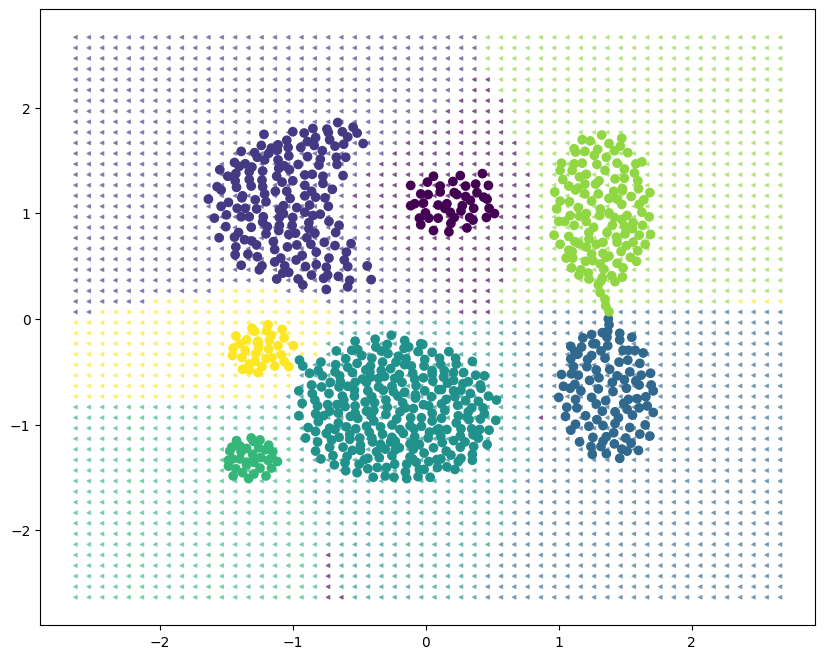

In [58]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('/content/Aggregation.txt',delim_whitespace=True, skiprows=7)
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(set(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

gamma = 1
C = 2

models = svm_train_multiclass(x_train, y_train, C, gamma )
predictions2 = predict_multiclass(models,x_test, gamma)
print(y_test)
print(predictions2)
print("The accuracy is " ,accuracy_score(y_test, predictions2))

visualization(X,y,models)

{1, 2, 3, 4, 5, 6}
     pcost       dcost       gap    pres   dres
 0: -2.2469e+01 -5.2169e+02  2e+03  2e+00  6e-16
 1: -1.7211e+01 -2.4715e+02  3e+02  4e-02  6e-16
 2: -2.0227e+01 -6.4749e+01  5e+01  7e-03  5e-16
 3: -2.3808e+01 -3.3654e+01  1e+01  4e-04  4e-16
 4: -2.4992e+01 -2.7458e+01  2e+00  7e-05  4e-16
 5: -2.5399e+01 -2.5999e+01  6e-01  7e-06  4e-16
 6: -2.5456e+01 -2.5876e+01  4e-01  3e-06  3e-16
 7: -2.5557e+01 -2.5620e+01  6e-02  3e-07  4e-16
 8: -2.5574e+01 -2.5589e+01  1e-02  1e-15  4e-16
 9: -2.5579e+01 -2.5582e+01  3e-03  3e-16  4e-16
10: -2.5580e+01 -2.5580e+01  1e-04  9e-16  3e-16
11: -2.5580e+01 -2.5580e+01  2e-06  5e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2014e+01 -4.4495e+02  2e+03  2e+00  6e-16
 1: -5.1037e+00 -1.7937e+02  2e+02  1e-02  6e-16
 2: -1.1764e+01 -3.8056e+01  3e+01  1e-03  6e-16
 3: -1.4996e+01 -2.2090e+01  7e+00  2e-04  5e-16
 4: -1.5988e+01 -1.7486e+01  1e+00  3e-05  4e-16
 5: -1.6191e+01 -1.6502e+01 

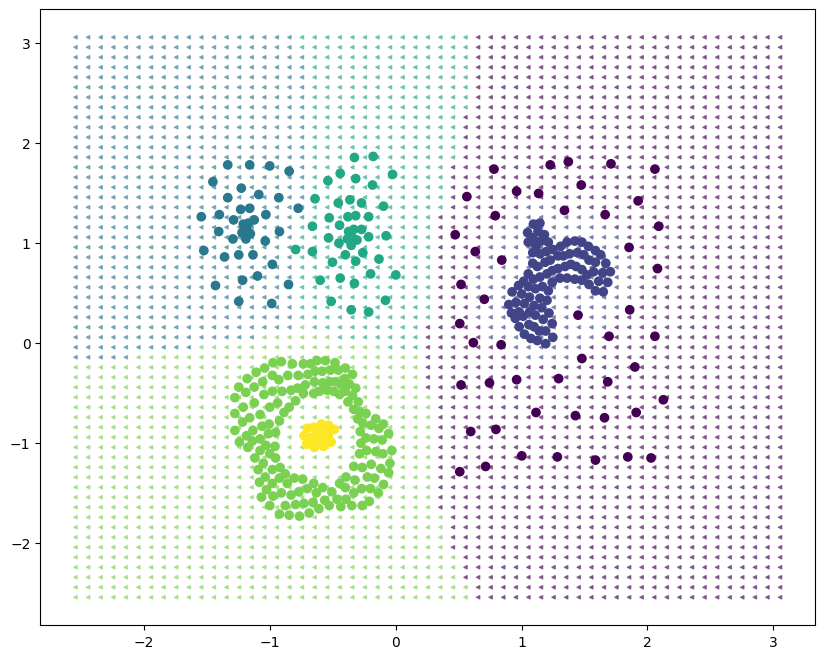

In [59]:
df = pd.read_csv('/content/Compound.txt',delim_whitespace=True, skiprows=7)
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(set(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x = np.asarray(x)
y = np.asarray(y)

C = 1
gamma = 5

models = svm_train_multiclass(x_train, y_train, C, gamma )
predictions2 = predict_multiclass(models,x_test, gamma)
print(y_test)
print(predictions2)
print("The accuracy is " ,accuracy_score(y_test, predictions2))

#we need to choose the best model first
visualization(X,y,models)

{1, 2}
     pcost       dcost       gap    pres   dres
 0:  1.7917e+00 -5.2612e+02  5e+02  2e-14  7e-16
 1: -1.3359e+01 -6.8669e+01  6e+01  5e-15  8e-16
 2: -1.7780e+01 -2.9955e+01  1e+01  2e-16  5e-16
 3: -1.8988e+01 -2.0805e+01  2e+00  2e-16  5e-16
 4: -1.9310e+01 -1.9690e+01  4e-01  2e-16  4e-16
 5: -1.9394e+01 -1.9496e+01  1e-01  9e-16  5e-16
 6: -1.9414e+01 -1.9434e+01  2e-02  3e-16  5e-16
 7: -1.9420e+01 -1.9421e+01  1e-03  2e-16  4e-16
 8: -1.9420e+01 -1.9420e+01  5e-05  2e-16  5e-16
 9: -1.9420e+01 -1.9420e+01  2e-06  5e-16  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.7917e+00 -5.2612e+02  5e+02  2e-14  7e-16
 1: -1.3359e+01 -6.8669e+01  6e+01  5e-15  8e-16
 2: -1.7780e+01 -2.9955e+01  1e+01  2e-16  5e-16
 3: -1.8988e+01 -2.0805e+01  2e+00  2e-16  5e-16
 4: -1.9310e+01 -1.9690e+01  4e-01  2e-16  4e-16
 5: -1.9394e+01 -1.9496e+01  1e-01  9e-16  5e-16
 6: -1.9414e+01 -1.9434e+01  2e-02  3e-16  5e-16
 7: -1.9420e+01 -1.9421e+01  1e-03  2e-1

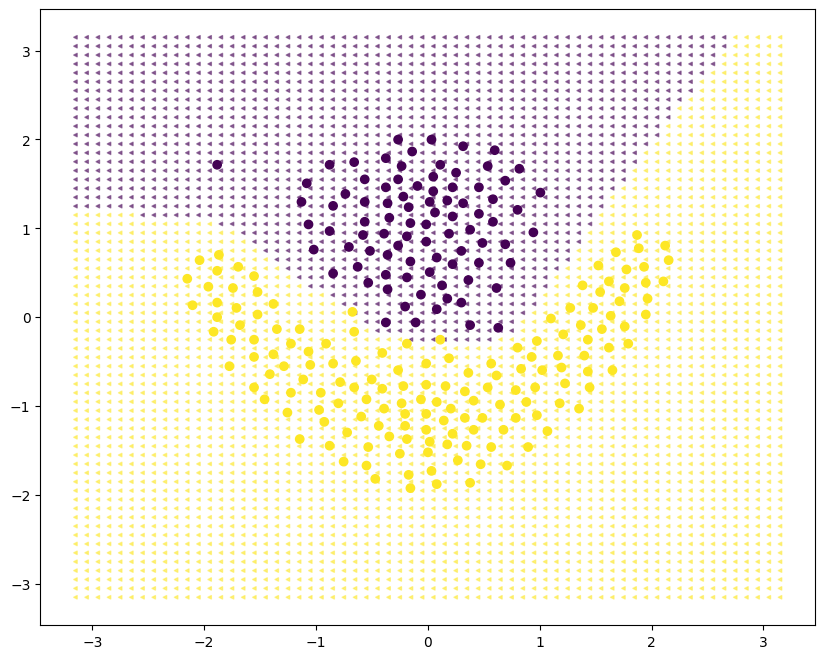

In [60]:

df = pd.read_csv('/content/Flame.txt',delim_whitespace=True, skiprows=7)
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(set(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x = np.asarray(x)
y = np.asarray(y)

C = 2
gamma = 5

models = svm_train_multiclass(x_train, y_train, C, gamma )
predictions2 = predict_multiclass(models,x_test, gamma)
print(y_test)
print(predictions2)
print("The accuracy is " ,accuracy_score(y_test, predictions2))
visualization(X,y,models)

{1, 2}
     pcost       dcost       gap    pres   dres
 0: -6.1686e+00 -3.5661e+02  1e+03  1e+00  5e-16
 1: -7.6788e-01 -1.3444e+02  1e+02  8e-16  6e-16
 2: -8.4835e+00 -2.9788e+01  2e+01  9e-16  6e-16
 3: -9.9084e+00 -1.7877e+01  8e+00  2e-16  3e-16
 4: -1.0582e+01 -1.2843e+01  2e+00  9e-16  3e-16
 5: -1.0974e+01 -1.1589e+01  6e-01  1e-15  3e-16
 6: -1.1109e+01 -1.1248e+01  1e-01  2e-16  3e-16
 7: -1.1147e+01 -1.1170e+01  2e-02  2e-15  3e-16
 8: -1.1155e+01 -1.1156e+01  2e-03  2e-15  3e-16
 9: -1.1155e+01 -1.1155e+01  4e-05  5e-15  3e-16
10: -1.1155e+01 -1.1155e+01  5e-07  1e-15  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.1686e+00 -3.5661e+02  1e+03  1e+00  5e-16
 1: -7.6788e-01 -1.3444e+02  1e+02  8e-16  6e-16
 2: -8.4835e+00 -2.9788e+01  2e+01  9e-16  6e-16
 3: -9.9084e+00 -1.7877e+01  8e+00  2e-16  3e-16
 4: -1.0582e+01 -1.2843e+01  2e+00  9e-16  3e-16
 5: -1.0974e+01 -1.1589e+01  6e-01  1e-15  3e-16
 6: -1.1109e+01 -1.1248e+01  1e-01  2e-1

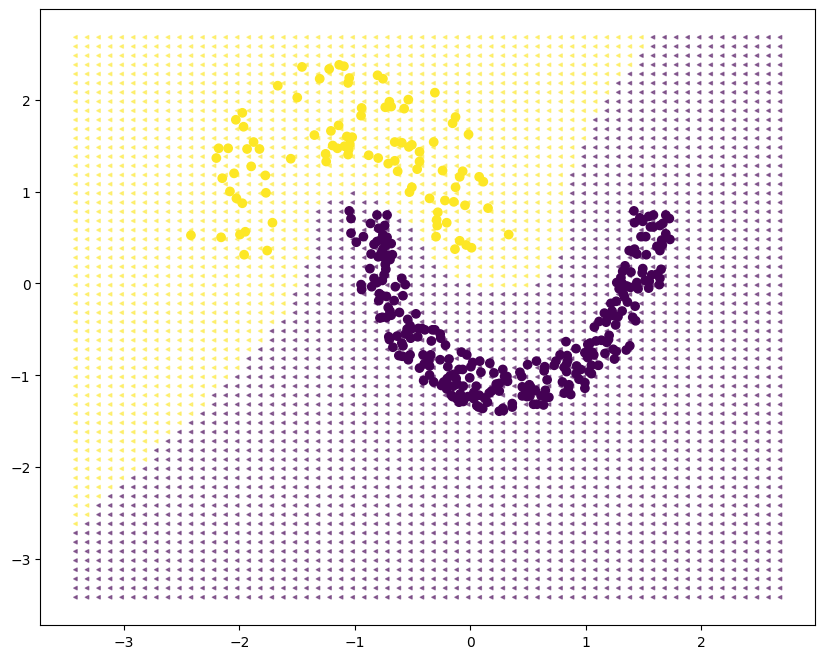

In [61]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/Jain.txt',delim_whitespace=True, skiprows=7)
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(set(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x = np.asarray(x)
y = np.asarray(y)

C = 1
gamma = 5

models = svm_train_multiclass(x_train, y_train, C, gamma )
predictions2 = predict_multiclass(models,x_test, gamma)
print(y_test)
print(predictions2)
print("The accuracy is " ,accuracy_score(y_test, predictions2))

visualization(X,y,models)

{1, 2, 3}
     pcost       dcost       gap    pres   dres
 0: -1.3653e+01 -3.2909e+02  3e+02  6e-15  6e-16
 1: -1.7215e+01 -3.7719e+01  2e+01  2e-15  5e-16
 2: -1.8002e+01 -2.2465e+01  4e+00  2e-15  2e-16
 3: -1.8210e+01 -1.9349e+01  1e+00  2e-16  2e-16
 4: -1.8335e+01 -1.8747e+01  4e-01  5e-16  2e-16
 5: -1.8385e+01 -1.8463e+01  8e-02  1e-15  2e-16
 6: -1.8395e+01 -1.8439e+01  4e-02  4e-16  2e-16
 7: -1.8405e+01 -1.8411e+01  6e-03  1e-15  2e-16
 8: -1.8406e+01 -1.8407e+01  8e-04  9e-16  2e-16
 9: -1.8406e+01 -1.8406e+01  8e-05  2e-15  2e-16
10: -1.8406e+01 -1.8406e+01  2e-06  6e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3312e+01 -3.2658e+02  3e+02  7e-15  5e-16
 1: -1.7038e+01 -3.7999e+01  2e+01  2e-15  4e-16
 2: -1.7849e+01 -2.2172e+01  4e+00  8e-16  2e-16
 3: -1.8055e+01 -1.9026e+01  1e+00  2e-16  2e-16
 4: -1.8164e+01 -1.8481e+01  3e-01  2e-16  2e-16
 5: -1.8222e+01 -1.8293e+01  7e-02  2e-16  2e-16
 6: -1.8237e+01 -1.8256e+01  2e-02  9

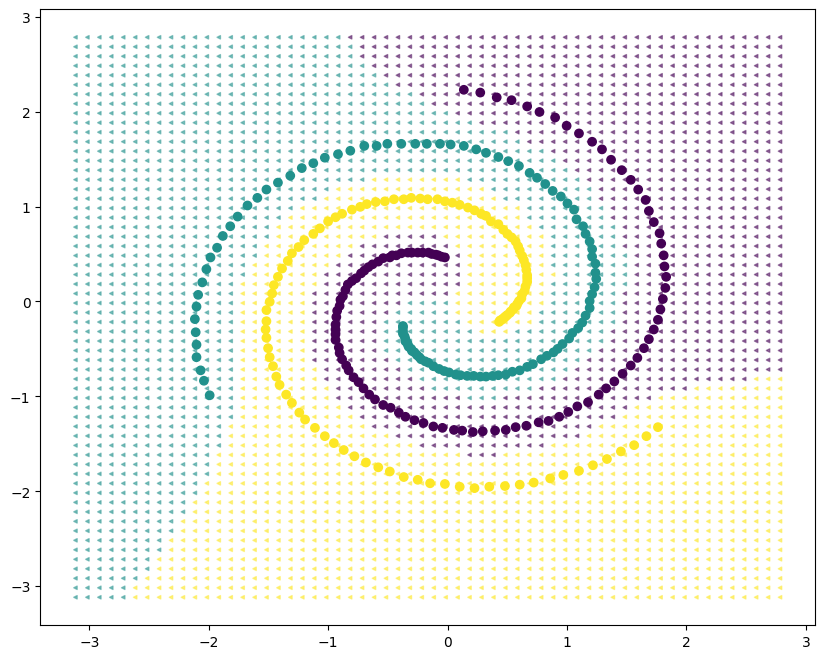

In [62]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/Spiral.txt',delim_whitespace=True, skiprows=7)
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(set(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x = np.asarray(x)
y = np.asarray(y)

C = 1
gamma = 5

models = svm_train_multiclass(x_train, y_train, C, gamma )
predictions2 = predict_multiclass(models,x_test, gamma)
print(y_test)
print(predictions2)
print("The accuracy is " ,accuracy_score(y_test, predictions2))

visualization(X,y,models)

{1, 2, 3}
     pcost       dcost       gap    pres   dres
 0: -1.2798e+01 -5.1167e+02  5e+02  6e-16  7e-16
 1: -2.2585e+01 -5.9582e+01  4e+01  2e-15  6e-16
 2: -2.5577e+01 -3.3536e+01  8e+00  6e-16  3e-16
 3: -2.6386e+01 -2.7969e+01  2e+00  8e-16  2e-16
 4: -2.6629e+01 -2.7119e+01  5e-01  1e-16  3e-16
 5: -2.6689e+01 -2.6830e+01  1e-01  2e-16  3e-16
 6: -2.6715e+01 -2.6740e+01  2e-02  8e-16  2e-16
 7: -2.6720e+01 -2.6724e+01  4e-03  5e-16  3e-16
 8: -2.6721e+01 -2.6721e+01  4e-04  2e-16  3e-16
 9: -2.6721e+01 -2.6721e+01  9e-06  8e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -6.6950e+00 -4.7185e+02  5e+02  9e-16  6e-16
 1: -1.5535e+01 -5.3790e+01  4e+01  4e-15  7e-16
 2: -1.7969e+01 -2.5312e+01  7e+00  2e-16  3e-16
 3: -1.8596e+01 -2.0097e+01  2e+00  1e-15  3e-16
 4: -1.8790e+01 -1.9074e+01  3e-01  6e-16  3e-16
 5: -1.8834e+01 -1.8904e+01  7e-02  1e-15  2e-16
 6: -1.8848e+01 -1.8861e+01  1e-02  5e-16  2e-16
 7: -1.8851e+01 -1.8852e+01  1e-03  2

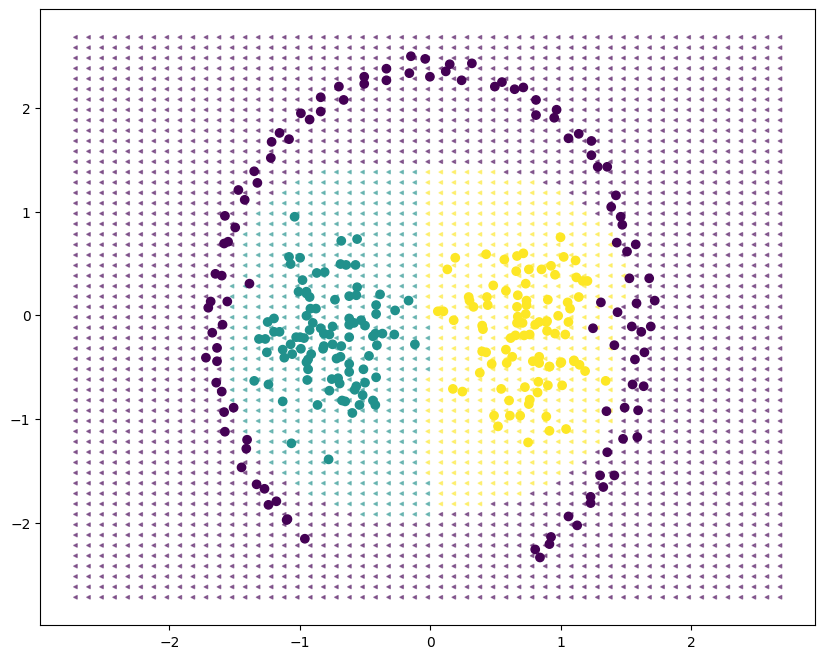

In [63]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('/content/Pathbased.txt',delim_whitespace=True, skiprows=7)
X = df.iloc[:,:-1].values
y = df.iloc[:, -1].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(set(y))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x = np.asarray(x)
y = np.asarray(y)

C = 1.5
gamma = 10

models = svm_train_multiclass(x_train, y_train, C, gamma )
predictions2 = predict_multiclass(models,x_test, gamma)
print(y_test)
print(predictions2)
print("The accuracy is " ,accuracy_score(y_test, predictions2))

visualization(X,y,models)

In [64]:
import numpy as np
import pandas as pd
import itertools


import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from mlxtend.plotting import plot_decision_regions
from mlxtend.preprocessing import shuffle_arrays_unison
import seaborn as sns

TRY on IRIS


In [67]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from math import sqrt
from collections import Counter
from sklearn.metrics import accuracy_score
iris = datasets.load_iris()

iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                      columns= iris['feature_names'] + ['target'])

iris_df_no_duplicates = iris_df.drop_duplicates()

x = iris_df.iloc[:,:-1]
y =iris_df.iloc[:,-1]


#split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state=0, shuffle = True)

x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x = np.asarray(x)
y = np.asarray(y)
# alpha,W,B = svm_train(x_train, y_train, C,'rbf')
# predictions = predict(x_test,W,B)
# print("The accuracy is " ,accuracy_score(y_test, predictions))


C = 0.1
gamma = 3

models = svm_train_multiclass(x_train, y_train, C, gamma )
predictions2 = predict_multiclass(models,x_test, gamma)
print(y_test)
print(predictions2)
print("The accuracy is " ,accuracy_score(y_test, predictions2))


     pcost       dcost       gap    pres   dres
 0: -6.1795e+00 -2.1570e+01  5e+02  2e+01  3e-16
 1: -4.5941e+00 -1.9788e+01  4e+01  9e-01  5e-16
 2: -4.1082e+00 -9.1707e+00  5e+00  4e-16  6e-16
 3: -4.2572e+00 -4.9654e+00  7e-01  3e-16  4e-16
 4: -4.3911e+00 -4.5926e+00  2e-01  4e-16  3e-16
 5: -4.4345e+00 -4.4819e+00  5e-02  2e-16  3e-16
 6: -4.4492e+00 -4.4581e+00  9e-03  2e-16  3e-16
 7: -4.4525e+00 -4.4534e+00  9e-04  2e-16  3e-16
 8: -4.4529e+00 -4.4529e+00  3e-05  2e-16  3e-16
 9: -4.4529e+00 -4.4529e+00  7e-07  2e-16  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.2057e+01 -2.6435e+01  7e+02  2e+01  4e-16
 1: -6.5266e+00 -2.3956e+01  5e+01  1e+00  5e-16
 2: -5.2839e+00 -1.1743e+01  6e+00  8e-16  7e-16
 3: -5.5430e+00 -6.4719e+00  9e-01  4e-16  5e-16
 4: -5.7143e+00 -5.8724e+00  2e-01  2e-16  4e-16
 5: -5.7544e+00 -5.8034e+00  5e-02  2e-16  3e-16
 6: -5.7696e+00 -5.7805e+00  1e-02  2e-16  3e-16
 7: -5.7736e+00 -5.7750e+00  1e-03  2e-16  4e-1